<a href="https://colab.research.google.com/github/kpopn9420/Deep-Virtual-Try-On/blob/master/HW5_1090407.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notice: 

1.   Please add data augmentation code by yourself!
2.   Download submission.csv and submit to Kaggle


---










In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.python.keras.models import load_model 
from tensorflow.keras.models import Model
import h5py 
from keras.preprocessing.image import ImageDataGenerator

from skimage import io

import imgaug.augmenters as iaa
import imgaug as ia

#### Download dataset

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# unzip dataset file 
# Plase Modify to your own file path!!!! 
!unzip -q '/content/drive/MyDrive/pneumonia-kaggle.zip'

#### Prepare dataset


In [ ]:
IMG_SIZE = 200
BATCH_SIZE = 64

all_class = ['normal', 'bacteria', 'virus']
class_map = {cls:i for i,cls in enumerate(all_class)} #  'normal':0, 'bacteria': 1, 'virus':2
class_map

{'normal': 0, 'bacteria': 1, 'virus': 2}

In [ ]:
# read all paths
img_paths_all = glob('pneumonia-kaggle/train/*/*.jpeg')
img_paths_test = sorted(glob('pneumonia-kaggle/test/*.jpeg'))
img_paths_train, img_paths_val = train_test_split(img_paths_all, test_size=0.2)

In [ ]:
# number of images
len(img_paths_train), len(img_paths_val), len(img_paths_test)

(4172, 1044, 624)

In [ ]:
class DataGenerator(utils.Sequence):
    def __init__(self, paths, batch_size, img_size, mode='train', aug=False):
        self.paths = paths
        self.batch_size = batch_size
        self.shuffle = mode == 'train'
        self.indexes = np.arange(len(self.paths))
        all_class = ['normal', 'bacteria', 'virus']
        self.class_map = {cls:i for i,cls in enumerate(all_class)}
        self.num_classes = len(self.class_map)
        self.img_size = img_size
        self.aug = aug
        self.seq = iaa.Sequential([
            iaa.Affine(
                rotate=(-10, 10), # random rotate -45 ~ +45 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.mode = mode
        self.on_epoch_end()

    def __len__(self):
        'number of batches per epoch'
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_paths = [self.paths[i] for i in idxs]
        # Generate data
        return self.__data_generation(batch_paths)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, paths):
        """
        Generates data containing batch_size samples
        """
        x = np.empty((len(paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(paths)))

        for i, path in enumerate(paths):
            img = cv2.imread(path)[:,:,::-1]
            # img preprocess
            img = cv2.resize(img, (self.img_size, self.img_size))
            ######### Modify your preprocess 前處理請依選用模型定義 !!!!!! ##########
            img = tf.keras.applications.vgg16.preprocess_input(img)
            if self.mode != 'test':
                # read class label
                cls = path.split(os.sep)[-2].lower()
                if cls == 'pneumonia':
                    # get filename
                    filename = path.split(os.sep)[-1]
                    # get pneumonia subclass
                    cls_pneumonia = filename.split('_')[1] 
                    cls_idx = class_map[cls_pneumonia]
                # for normal class
                else:
                    cls_idx = class_map[cls]
                y[i] = cls_idx
            x[i] = img

        if self.mode != 'test':            
            # one-hot encoding
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            if self.aug:
              x = self.augmentation(x)
            return x, y
        else:
          return x
            
    def augmentation(self, imgs):
       return self.seq.augment_images(imgs)

In [ ]:
gen_train = DataGenerator(img_paths_train, BATCH_SIZE, IMG_SIZE, mode='train', aug=True)
gen_val = DataGenerator(img_paths_val, BATCH_SIZE, IMG_SIZE, mode='val', aug=True)
gen_test = DataGenerator(img_paths_test, BATCH_SIZE, IMG_SIZE, mode='test')

### Build model

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classifier_activation="softmax",
    )

x = layers.GlobalAveragePooling2D()(base_model.output) 
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(3, activation='softmax')(x)

for l in base_model.layers:
    l.trainable = False
    
model = models.Model(base_model.input, x)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

#### Training

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [12]:
logs = model.fit(gen_train,
          batch_size=32,       
          epochs=1000,
          callbacks=[
                     tf.keras.callbacks.EarlyStopping(patience=10),
                     tf.keras.callbacks.ModelCheckpoint('./best.h5', save_best_only=True,),
                     tf.keras.callbacks.ModelCheckpoint('./last.h5', save_best_only=False,),
                     tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3),
          ],
          validation_data=gen_val)

Epoch 1/1000
66/66 [==============================] - 147s 2s/step - loss: 1.1194 - accuracy: 0.6055 - val_loss: 0.6590 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 2/1000
66/66 [==============================] - 129s 2s/step - loss: 0.6582 - accuracy: 0.7064 - val_loss: 0.5781 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 3/1000
66/66 [==============================] - 129s 2s/step - loss: 0.5939 - accuracy: 0.7325 - val_loss: 0.5768 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 4/1000
66/66 [==============================] - 127s 2s/step - loss: 0.5759 - accuracy: 0.7402 - val_loss: 0.5506 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 5/1000
66/66 [==============================] - 128s 2s/step - loss: 0.5582 - accuracy: 0.7639 - val_loss: 0.5468 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 6/1000
66/66 [==============================] - 127s 2s/step - loss: 0.5364 - accuracy: 0.7661 - val_loss: 0.5241 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 7/1000
66/66 [==============================] - 128s 2s/st

#### Training logs

In [14]:
history = logs.history
min_loss_epoch = np.argmin(history['val_loss'])
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

val loss  0.4658414125442505
val acc 0.8026819825172424


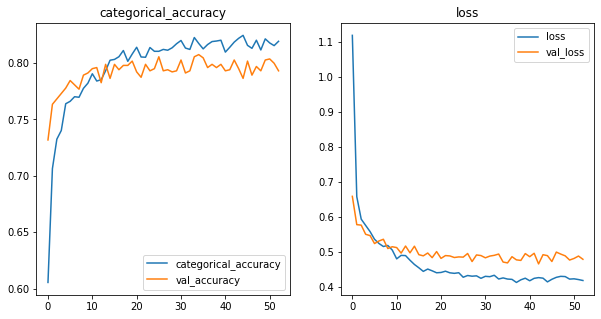

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['categorical_accuracy', 'val_accuracy'])
plt.title('categorical_accuracy')
plt.subplot(1,2,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.show()

#### Metrics

In [17]:
# load best model
model2 = tf.keras.models.load_model('./best.h5')

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.array([])
y_true = np.array([])
for x_val, y_val in tqdm(gen_val):
    pred = model.predict(x_val)
    y_pred = np.append(y_pred, np.argmax(pred, axis=-1))
    y_true = np.append(y_true, np.argmax(y_val, axis=-1))

  0%|          | 0/17 [00:00<?, ?it/s]

1/1 [==============================] - 0s 133ms/step


In [19]:
# classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93       241
         1.0       0.81      0.85      0.83       535
         2.0       0.69      0.59      0.63       268

    accuracy                           0.81      1044
   macro avg       0.80      0.80      0.80      1044
weighted avg       0.80      0.81      0.80      1044



In [20]:
# Confusion matrix:
#   row: Ground truth
#   column: predict
print(confusion_matrix(y_true, y_pred))

[[229   6   6]
 [ 13 456  66]
 [ 12  99 157]]


#### Make Kaggle Submission

In [21]:
predictions = np.argmax(model.predict(gen_test), axis=-1)

10/10 [==============================] - 18s 2s/step


In [22]:
df = pd.DataFrame()
df['Id'] = [f'{i:03d}.jpeg' for i in range(len(img_paths_test))]
df['Category'] = predictions.astype(int)
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,000.jpeg,2
1,001.jpeg,1
2,002.jpeg,1
3,003.jpeg,1
4,004.jpeg,0
...,...,...
619,619.jpeg,1
620,620.jpeg,0
621,621.jpeg,0
622,622.jpeg,1


In [23]:
# 1. save whole model and weights
model.save('my_model.h5')
model2 = models.load_model('my_model.h5')

In [24]:
# 2. save and load weights only
model.save_weights('my_model_weights.h5')

# Rebuild model before load weights !
model2 = models.Model(base_model.input, x)
model2.load_weights('my_model_weights.h5')